# My Anime List dataset
## 1. Предобработка

In [25]:
import numpy  as np
import pandas as pd

df = pd.read_csv("data/raw/user_data.csv")

В качестве данных колонки _location_ зачастую указны несуществующие локации:

In [2]:
print(df.loc[[3, 5, 2192]].location.to_string())

3              Fish tank. I'm stuck.
5                              Wired
2192    In a Galaxy far, far away...


Также может быть указан и нереалистичный возраст:

In [3]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

last_date = df.last_online.map(lambda x: datetime.strptime(x[:10], "%Y-%m-%d")).max()
def countYears(date):
    if pd.notna(date):
        return relativedelta(last_date, datetime.strptime(date[:10], "%Y-%m-%d")).years
    return pd.NA

df = df.assign(age=df.birthday.apply(countYears))
df.loc[(df.age <= 4) | (df.age >= 90)].head(2)

,name,planning,watched,completed,days_watched,dropped,episodes_watched,mean_score,on_hold,plan_to_watch,...,total_entries,watching,birthday,gender,joined,last_online,location,favorites,genre_count,age
1,-Droid-,"[{'mal_id': 6408, 'title': '""Bungaku Shoujo"" M...","[{'title': '11eyes', 'mal_id': 6682, 'score': ...",1125,263.3,4,16195,7.80,4,1131,...,2271,7,1930-01-07T00:00:00+00:00,Male,2013-09-07T00:00:00+00:00,2020-09-17 21:07:00+00:00,MA,"{'anime': [{'mal_id': 237, 'title': 'Koukyoush...","{'Action': 447, 'Adventure': 186, 'Cars': 1, '...",90
8,-Neko,"[{'mal_id': 34437, 'title': 'Code Geass: Fukka...","[{'title': '07-Ghost', 'mal_id': 5525, 'score'...",430,113.8,11,6763,7.68,0,16,...,556,99,1930-02-16T00:00:00+00:00,Non-Binary,2016-06-01T00:00:00+00:00,2020-09-20 18:20:00+00:00,Antarctica,"{'anime': [], 'characters': [], 'people': []}","{'Action': 200, 'Adventure': 49, 'Cars': 0, 'C...",90


Также будем считать, что человек не может посмотреть 20000 часов аниме. Таким образом:
* графу _location_ невозможно как-либо исправить и ее стоит отбросить.
* графа _name_ также плохо поддается анализу.
* в графе _birthday_ стоит считать валидным возраст от 3 и до 90 лет.
* добавим графу возраста _age_ как разность между днем рождения самым поздним онлайном на сайте.
* в графе _days watched_ стоит считать валидным кол-во часов не превышающее 20000.

In [4]:
del df['location']
del df['name']
df = df.loc[(df.age >= 3) & (df.age <= 90)]
df = df.loc[df.days_watched * 24 <= 20000]
df.to_csv('data/raw/corrected_user_data.csv')

### Гистограмма

Сравним относительную популярность аниме жанров сёнен (для мальчиков 12-18 лет) и сёдзё (для девочек 12-18 лет) среди мужчин и женщин.

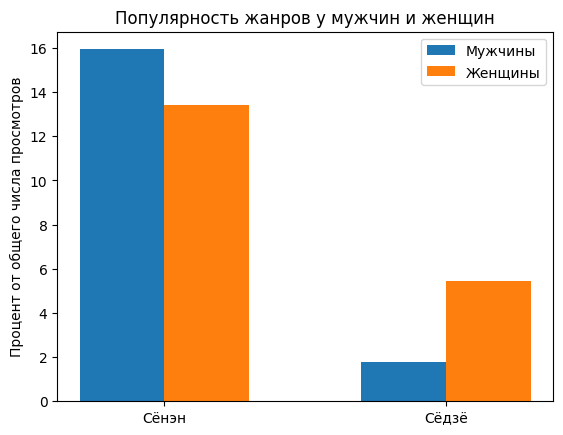

In [5]:
import matplotlib.pyplot as plt
from functools import reduce
from ast import literal_eval

def getGenres(dataframe):
    dist = literal_eval(reduce(lambda a, b: a + "," + b, dataframe.genre_count.to_list()))
    return pd.DataFrame(dist)

(male_df, female_df) = (df.loc[df.gender == 'Male'], df.loc[df.gender == 'Female'])
(genres_m, genres_f) = (getGenres(male_df).sum(), getGenres(female_df).sum())
(total_m, total_f)   = (male_df.total_entries.sum(), female_df.total_entries.sum())

plt.bar([0,     1], [genres_m.Shounen / total_m * 100, genres_m.Shoujo / total_m * 100], 0.3, label="Мужчины")
plt.bar([0.3, 1.3], [genres_f.Shounen / total_f * 100, genres_f.Shoujo / total_f * 100], 0.3, label="Женщины")

plt.xticks([0.15, 1.15], ["Сёнэн", "Сёдзё"])
plt.ylabel("Процент от общего числа просмотров")
plt.title("Популярность жанров у мужчин и женщин")

plt.legend(loc="upper right")
plt.show()

Видим ожидаемую закономерность: жанр для девушек более популярен у женской аудитории (почти в 3 раза по сравнению с мужчинами). Значительную количественную разницу между сёненом и сёдзё можно объяснить тем, что в первом жанре выходит намного больше аниме, чем во втором (нормирование происходило по общему числу просмотров для мужчин и для женщин).

### График

Построим график, показывающий соответствие между числом пользователей и просмотренным ими аниме.

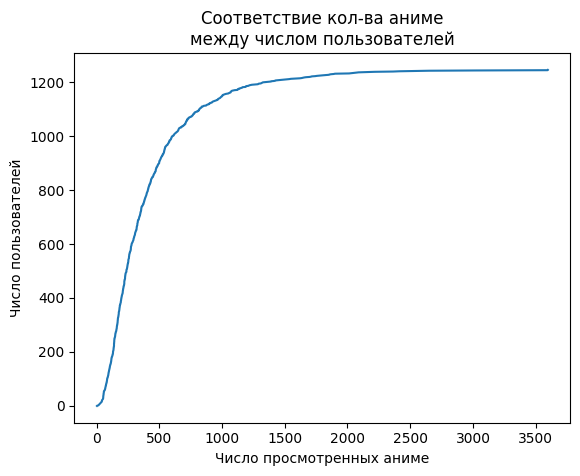

In [6]:
full_completed = df.completed.sort_values()
plt.plot(full_completed, np.arange(0, len(full_completed)))
plt.xlabel("Число просмотренных аниме")
plt.ylabel("Число пользователей")
plt.title("Соответствие кол-ва аниме\nмежду числом пользователей")
plt.show()

Заметим, что на отметке до 1000 аниме находится до 90% пользователей.

### 2D-гистограммы

Рассмотрим 2D-график: по оси X - возраст, по оси Y - время, потраченное на просмотр.

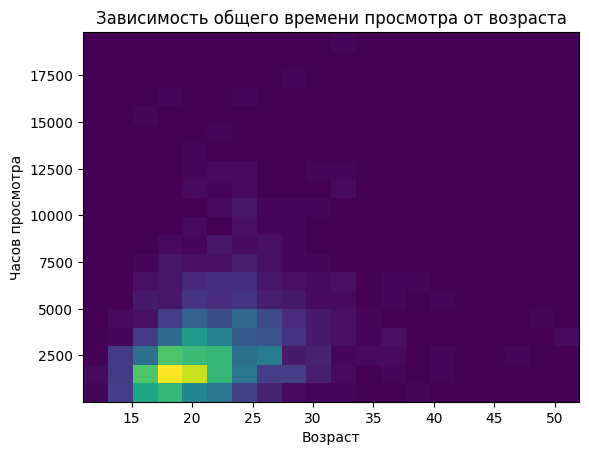

In [7]:
age = df[df.age <= 60]
plt.hist2d(age.age, age.days_watched * 24, bins=20)
plt.xlabel("Возраст")
plt.ylabel("Часов просмотра")
plt.title("Зависимость общего времени просмотра от возраста")
plt.show()

Среднестатистическому пользователю около 20 лет и он потратил на просмотр аниме около 1000 часов.

### Диаграмма рассеяния

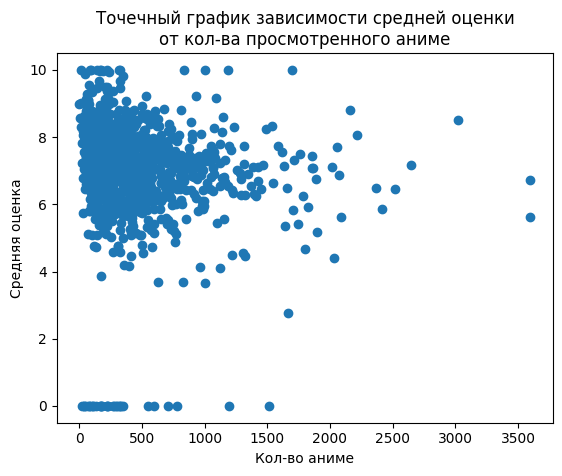

In [8]:
plt.scatter(df.completed, df.mean_score)
plt.xlabel("Кол-во аниме")
plt.ylabel("Средняя оценка")
plt.title("Точечный график зависимости средней оценки\nот кол-ва просмотренного аниме")
plt.show()

### Boxplot

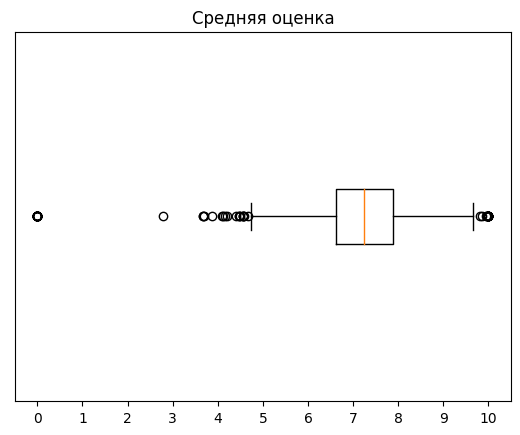

In [9]:
plt.boxplot(df.mean_score, vert=False)
plt.xticks(np.arange(0, 11))
plt.yticks([])
plt.title("Средняя оценка")
plt.show()

### 3D-график

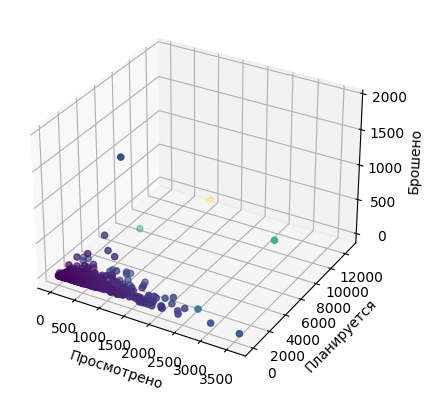

In [10]:
plot3d = plt.axes(projection='3d')
plot3d.scatter(df.completed, df.plan_to_watch + df.watching, df.dropped, c=df.total_entries)
plot3d.set_xlabel("Просмотрено")
plot3d.set_ylabel("Планируется")
plot3d.set_zlabel("Брошено")
plt.show()

### Новая колонка

Построим новую колонку - зависимость кол-ва просмотренных серий за год.

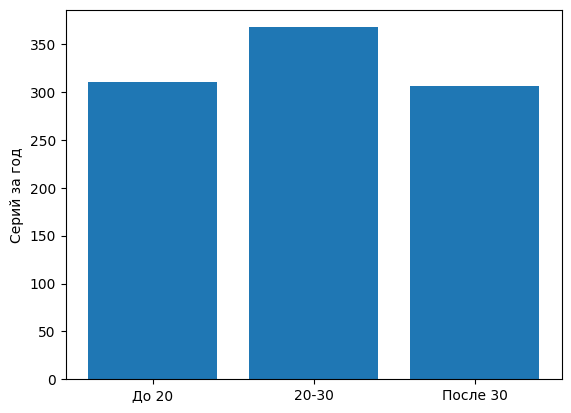

In [11]:
df['series_per_year'] = df.episodes_watched / df.age
plt.bar([0, 1, 2],
        [df.loc[df.age < 20].series_per_year.mean(),
         df.loc[(df.age >= 20) & (df.age <= 30)].series_per_year.mean(),
         df.loc[df.age > 30].series_per_year.mean()])
plt.xticks([0, 1, 2], ["До 20", "20-30", "После 30"])
plt.ylabel("Серий за год")
plt.show()

## 2. Интерполяция кривой

### 1. Интерполяция с scipy

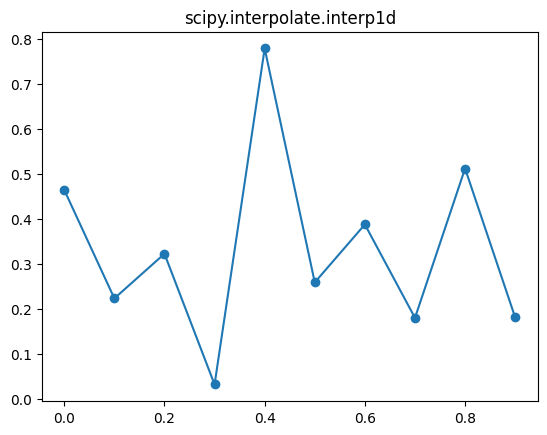

In [12]:
import scipy.interpolate

n = 10

np.random.seed(0xff)
xs = np.arange(0, 1, 0.1)
ys = np.random.random_sample(n)
p = scipy.interpolate.interp1d(xs, ys)

step = 1 / 512
x = np.arange(xs[0], xs[-1], step)

plt.plot(x, p(x))
plt.scatter(xs, ys)

plt.title("scipy.interpolate.interp1d")
plt.show()

Реализация [__scipy.interpolate.interp1d__](https://github.com/scipy/scipy/blob/47bb6febaa10658c72962b9615d5d5aa2513fa3a/scipy/interpolate/interpolate.py#L608) (метод \_call_linear).

Геометрический смысл: интерполяция между двумя точками - отрезок прямой, проходящей через эти две точки.

Формула для вычисления: `f(x) = y0 + (y1 - y0) / (x1 - x0) * (x - x0)`

### 2. Akima interpolation

Интерполяция [сплайном Акима](https://en.wikipedia.org/wiki/Akima_spline).

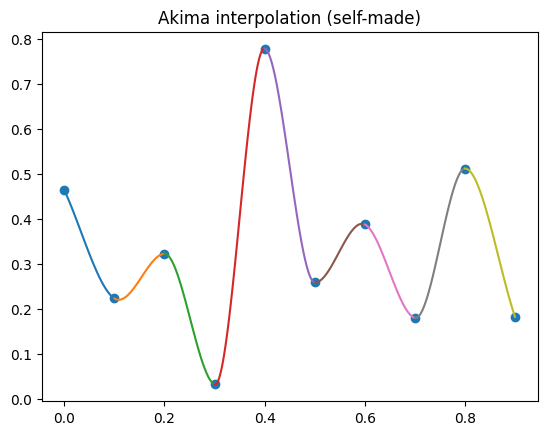

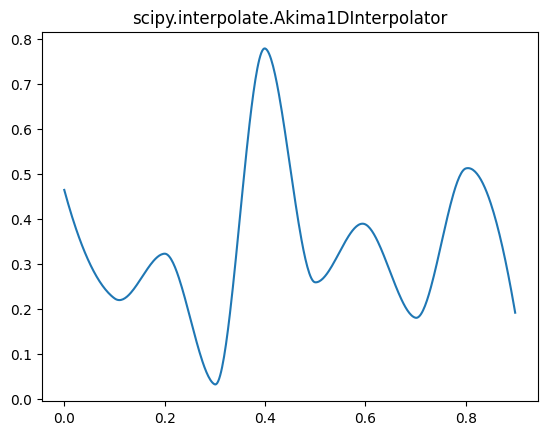

In [13]:
def akima(i, xs, ys):
    n = len(xs)
    def m(i):
        return (ys[i + 1] - ys[i]) / (xs[i + 1] - xs[i])
    def s(i):
        if i == 0: return m(0)
        if i == 1: return (m(0) + m(1)) / 2
        if i == n - 2: return (m(n - 3) + m(n - 2)) / 2
        if i == n - 1: return m(n - 2)
        denom = abs(m(i + 1) - m(i)) + abs(m(i - 1) - m(i - 2))
        if denom == 0: return (m(i - 1) + m(i)) / 2
        return (abs(m(i + 1) - m(i)) * m(i - 1) + abs(m(i - 1) - m(i - 2)) * m(i)) / denom
    
    a_i = ys[i]
    b_i = s(i)
    c_i = (3 * m(i) - 2 * s(i) - s(i + 1)) / (xs[i + 1] - xs[i])
    d_i = (s(i) + s(i + 1) - 2 * m(i)) / (xs[i + 1] - xs[i]) ** 2
    
    return lambda x: a_i + b_i * (x - xs[i]) + c_i * (x - xs[i]) ** 2 + d_i * (x - xs[i]) ** 3

# akima
for i in np.arange(0, n - 1):
    x = np.arange(xs[i], xs[i + 1], step)
    p = akima(i, xs, ys)
    plt.plot(x, p(x))
plt.scatter(xs, ys)
plt.title("Akima interpolation (self-made)")
plt.show()

# scipy
x = np.arange(xs[0], xs[-1], step)
p = scipy.interpolate.Akima1DInterpolator(xs, ys)
plt.plot(x, p(x))
plt.title("scipy.interpolate.Akima1DInterpolator")
plt.show()

Ближе к экстремумам точки теряются или немного отличаются:
- можно подобрать более правильный (возможно адаптивный) шаг по оси X.
- можно использовать другие крайние значения для коэффициента `m_i`.

## 3. Быстрая гистограмма

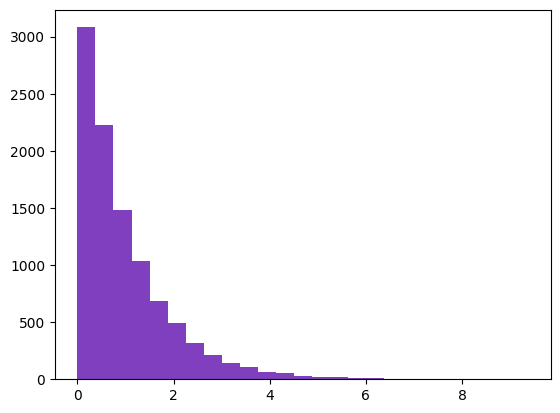

In [14]:
from typing import List, Tuple, Union

def fast_hist(array: List[Union[int, float]], 
              bins: int) -> Tuple[List[int], List[float]]:
    (_, min) = reduce(lambda a, b: b if a[1] > b[1] else a, array)
    (_, max) = reduce(lambda a, b: b if a[1] < b[1] else a, array)

    step = (max - min) / bins
    heights = np.zeros(bins)

    for (_, val) in array:
        x = int((val - min) / step)
        heights[np.minimum(x, bins - 1)] += 1
    return (np.arange(min, max, step), heights)

xs = np.random.exponential(size = 10000)
xsi = list(zip(np.arange(0, 10000), xs))

plt.hist(xs, color='red', bins=25, alpha = 0.5)
(i, h) = fast_hist(xsi, bins=25)
width=i[1]-i[0]
plt.bar(i + width / 2, h, width=width, color='blue', alpha = 0.5)
plt.show()

In [15]:
def test(n):
    global testData1
    global testData2
    plt.clf()

    xs = np.random.exponential(size = n)
    xsi = list(zip(np.arange(0, n), xs))
    testData1 = xs
    testData2 = xsi

In [16]:
%%capture --no-stderr capturedLib
%%timeit -n1 -r10 test(1000)
plt.hist(testData1, bins=25)

In [17]:
%%capture --no-stderr capturedOwn
%%timeit -n1 -r10 test(1000)
fast_hist(testData2, bins=25)

In [18]:
print("Test on 1000 values:"
      "\n* Matplotlib: " + capturedLib.stdout.strip(),
      "\n* fast_hist: "  + capturedOwn.stdout.strip())

Test on 1000 values:
* Matplotlib: 25.5 ms +- 1.69 ms per loop (mean +- std. dev. of 10 runs, 1 loop each) 
* fast_hist: 2.34 ms +- 319 us per loop (mean +- std. dev. of 10 runs, 1 loop each)


In [19]:
%%capture --no-stderr capturedLib
%%timeit -n1 -r10 test(100000)
plt.hist(testData1, bins=25)

In [20]:
%%capture --no-stderr capturedOwn
%%timeit -n1 -r10 test(100000)
fast_hist(testData2, bins=25)

In [21]:
print("Test on 100000 values:"
      "\n* Matplotlib: " + capturedLib.stdout.strip(),
      "\n* fast_hist: "  + capturedOwn.stdout.strip())

Test on 100000 values:
* Matplotlib: 28.1 ms +- 1.06 ms per loop (mean +- std. dev. of 10 runs, 1 loop each) 
* fast_hist: 211 ms +- 10.1 ms per loop (mean +- std. dev. of 10 runs, 1 loop each)
